In [1]:
from ipywidgets import FloatProgress, IntText
import time
import collections
from math import log 
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def save_object(obj, filename):
    with open(filename, 'wb') as outfile:  
        pickle.dump(obj, outfile, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('data/is_male.pkl', 'rb') as infile:
    is_male = pickle.load(infile)

In [4]:
import sys
print("Python version + compiler & build info:", sys.version)
print("Jupyter notebook version:", os.popen("jupyter notebook --version").readlines()[0])

Python version + compiler & build info: 3.6.5 |Anaconda custom (64-bit)| (default, Mar 29 2018, 18:21:58) 
[GCC 7.2.0]
Jupyter notebook version: 5.4.1



# Create Counters of Bigrams in Biographies of Women and Men, in Batches

In [3]:
# This is purportedly the fastest way to get bigrams
def get_bigrams(text):
    return zip(*[text[i:] for i in range(2)])

In [5]:
# This cell takes about 46 minutes to run.

male_bigrams = collections.Counter()
female_bigrams = collections.Counter()

print("Building batches of counters for bigrams found in all Wiki bios of women and of men...")
print("Estimated time for completion: 46 minutes")

fp = FloatProgress(min=0, max=850399)
all_articles = IntText(value=0, description="Article Count:")
display(fp, all_articles)
article_count = 0

if not os.path.exists('data/bigrams'):
    os.makedirs('data/bigrams')

start = time.time()
try:
    with open("data/gendered-labeled-articles.stripped", 'r') as f:
        for line in f:
            article_count += 1
            all_articles.value += 1
            if article_count % 1000 == 0:
                fp.value = article_count
            line = line.split()
            male = is_male[line.pop(0)]
            # Read text in batches of 100 words
            line = [line[i-1 : i+99] for i in range(1, len(line), 99)]
            while line:
                bigrams = list(get_bigrams(line.pop(0)))
                if male:
                    male_bigrams.update(bigrams)
                else:
                    female_bigrams.update(bigrams)
            # Pickle results after every 1000 articles for men; 3000 for women (since we are using
            # a total article count, and we know there are fewer bios of women). These numbers seem
            # to be about right to prevent memory errors.
            if article_count % 1000 == 0:
                save_object(male_bigrams, 'data/bigrams/male_bigrams_{}.pkl'.format(article_count // 1000))
                male_bigrams = collections.Counter()
                if article_count % 3000 == 0:
                    save_object(female_bigrams, 'data/bigrams/female_bigrams_{}.pkl'.format(article_count // 3000))
                    female_bigrams = collections.Counter()
        save_object(male_bigrams, 'data/bigrams/male_bigrams_{}.pkl'.format(article_count // 1000 + 1))
        save_object(female_bigrams, 'data/bigrams/female_bigrams_{}.pkl'.format(article_count // 3000 + 1))
finally: 
    print("\nArticles:", article_count, "Time:", (time.time() - start), "seconds")

Building batches of counters for bigrams found in all Wiki bios of women and of men...
Estimated time for completion: 46 minutes


A Jupyter Widget

A Jupyter Widget


Articles: 850399 Time: 2681.5078961849213 seconds


In [6]:
total_batches_female = article_count // 3000 + 1  
total_batches_male = article_count // 1000 + 1 

print("Number of batches of bigrams for women collected:", total_batches_female)
print("Number of batches of bigrams for men collected:", total_batches_male)

Number of batches of bigrams for women collected: 284
Number of batches of bigrams for men collected: 851


In [7]:
# This cell takes about 10 minutes to run.

print("Merging batches of the female_bigrams counters. Removing bigrams with counts <= 2, six times.")

fp = FloatProgress(min=0, max=total_batches_female)
count = IntText(value=0, description="Count:")
display(fp, count)

f_count = 0
female_bigrams = collections.Counter()

start = time.time()
for i in range(1, total_batches_female + 1):
    fp.value += 1
    count.value += 1
    f_count += 1
    with open('data/bigrams/female_bigrams_{}.pkl'.format(i), 'rb') as infile:
        female_bigrams += pickle.load(infile)
        # Remove bigrams with counts <=2 six times.
        if f_count % 48 == 0:
            for k in set(k for k,v in female_bigrams.items() if v <= 2):
                del female_bigrams[k]
for k in set(k for k,v in female_bigrams.items() if v <= 2):
    del female_bigrams[k]  
save_object(female_bigrams, 'data/bigrams/female_bigrams_master.pkl')
print("Done.\nMaster counter for female bigrams saved in 'data/bigrams/female_bigrams_master.pkl'")
print("Time:", (time.time() - start), "seconds")

Merging batches of the female_bigrams counters. Removing bigrams with counts <= 2, six times.


A Jupyter Widget

A Jupyter Widget

Done.
Master counter for female bigrams saved in 'data/bigrams/female_bigrams_master.pkl'
Time: 552.6426672935486 seconds


In [8]:
print("Total number of distinct bigrams collected from bios of women:", len(female_bigrams))

Total number of distinct bigrams collected from bios of women: 2725813


In [9]:
print("Deleting temporary batches...")
for i in range(1, total_batches_female + 1):
    os.remove('data/bigrams/female_bigrams_{}.pkl'.format(i))
print("Done.")

Deleting temporary batches...
Done.


In [4]:
# This cell takes about 20 minutes to run.

# NOTE: If you get a memory error here, restart kernel and re-run first cell of notebook only.
# Then try again (a hacky way to solve memory issue that seems to work.)

# Delete female_bigrams to save memory.  We can load it later from pickle file.
# del female_bigrams
total_batches_male = 851

fp = FloatProgress(min=0, max=total_batches_male)
count = IntText(value=0, description="Count:")
m_count = 0
display(fp, count)

male_bigrams = collections.Counter()
n = 7

start = time.time()
for i in range(1, total_batches_male + 1):
    fp.value += 1
    count.value += 1
    m_count += 1
    with open('data/bigrams/male_bigrams_{}.pkl'.format(i), 'rb') as infile:
        male_bigrams += pickle.load(infile)
        # Remove bigrams with count <= n forty-eight times.
        if m_count % 18 == 0:
            for k in set(k for k,v in male_bigrams.items() if v <= n ):
                del male_bigrams[k]
            save_object(male_bigrams, 'data/bigrams/male_bigrams_b_{}.pkl'.format(m_count // 18))
            male_bigrams = collections.Counter()
# for k in set(k for k,v in male_bigrams.items() if v <= n ):
#     del male_bigrams[k]
save_object(male_bigrams, 'data/bigrams/male_bigrams_b_{}.pkl'.format(m_count // 18 + 1))
male_bigrams = collections.Counter()
print("Time:", (time.time() - start), "seconds")
print("Number of batches of male bigrams reduced to", m_count // 18 + 1)

A Jupyter Widget

A Jupyter Widget

Time: 1240.206268787384 seconds
Number of batches of male bigrams reduced to 48


In [9]:
# This cell takes less than 2 minutes to run.

fp = FloatProgress(min=0, max=48)
count = IntText(value=0, description="Count:")
display(fp, count)

print("Creating final master counter for male bigrams...")
print("This should take under 2 minutes...")

start = time.time()
for i in range(1, 49):
    fp.value += 1
    count.value += 1
    with open('data/bigrams/male_bigrams_b_{}.pkl'.format(i), 'rb') as infile:
        male_bigrams += pickle.load(infile)
# Limiting the number of bigrams to those with counts of 8 or more helps save memory
for k in set(k for k,v in male_bigrams.items() if v < 8):
    del male_bigrams[k]
save_object(male_bigrams, 'data/bigrams/male_bigrams_master.pkl')
print("Done.\nMaster counter for male bigrams saved in 'data/bigrams/male_bigrams_master.pkl'")
print("Time:", (time.time() - start), "seconds")
print("Total number of distinct bigrams collected from bios of men:", len(male_bigrams))

A Jupyter Widget

A Jupyter Widget

Creating final master counter for male bigrams...
This should take under 2 minutes...
Done.
Master counter for male bigrams saved in 'data/bigrams/male_bigrams_master.pkl'
Time: 35.66937756538391 seconds
Total number of distinct bigrams collected from bios of men: 1612684


In [12]:
print("Deleting temporary batches...")
for i in range(1, total_batches_male + 1):
    os.remove('data/bigrams/male_bigrams_{}.pkl'.format(i))
for i in range(1, m_count // 18 + 2):
    os.remove('data/bigrams/male_bigrams_b_{}.pkl'.format(i))
print("Done.")

Deleting temporary batches...
Done.


In [2]:
# Load female_bigrams_master:
with open('data/bigrams/female_bigrams_master.pkl', 'rb') as infile:
    female_bigrams = pickle.load(infile)

In [3]:
for k in set(k for k,v in female_bigrams.items() if v < 8):
    del female_bigrams[k]
len(female_bigrams)

1331985

In [4]:
# Load male_bigrams_master:
with open('data/bigrams/male_bigrams_master.pkl', 'rb') as infile:
    male_bigrams = pickle.load(infile)
len(male_bigrams)

1612684

# Exploratory Data Analysis of Bigrams

In [14]:
female_bigrams.most_common(70)

[(('http', 'www'), 813722),
 (('of', 'the'), 708824),
 (('ref', 'name'), 683958),
 (('url', 'http'), 578411),
 (('in', 'the'), 566040),
 (('ref', 'cite'), 448580),
 (('cite', 'web'), 440215),
 (('at', 'the'), 391527),
 (('web', 'url'), 299257),
 (('she', 'was'), 251644),
 (('women', 's'), 226877),
 (('for', 'the'), 190627),
 (('cite', 'news'), 179157),
 (('new', 'york'), 175253),
 (('to', 'the'), 173509),
 (('on', 'the'), 173402),
 (('and', 'the'), 169740),
 (('ref', 'http'), 160787),
 (('as', 'a'), 150900),
 (('birth', 'date'), 149470),
 (('ref', 'ref'), 144628),
 (('align', 'center'), 141886),
 (('united', 'states'), 121101),
 (('url', 'https'), 117811),
 (('in', 'a'), 110508),
 (('births', 'category'), 109660),
 (('ref', 'she'), 108566),
 (('living', 'people'), 107575),
 (('people', 'category'), 107094),
 (('archive', 'org'), 104657),
 (('category', 'american'), 104348),
 (('of', 'her'), 103947),
 (('university', 'of'), 102493),
 (('web', 'archive'), 100422),
 (('org', 'web'), 10027

In [15]:
male_bigrams.most_common(70)

[(('of', 'the'), 10743389),
 (('http', 'www'), 7115634),
 (('in', 'the'), 6708376),
 (('ref', 'name'), 6162263),
 (('url', 'http'), 4826060),
 (('ref', 'cite'), 3982254),
 (('he', 'was'), 3527017),
 (('cite', 'web'), 3441055),
 (('at', 'the'), 3024121),
 (('to', 'the'), 2744050),
 (('for', 'the'), 2462184),
 (('web', 'url'), 2362973),
 (('and', 'the'), 1935295),
 (('as', 'a'), 1894177),
 (('on', 'the'), 1864609),
 (('united', 'states'), 1833942),
 (('new', 'york'), 1697296),
 (('cite', 'news'), 1685356),
 (('birth', 'date'), 1576543),
 (('align', 'center'), 1555454),
 (('ref', 'http'), 1532831),
 (('players', 'category'), 1523481),
 (('with', 'the'), 1445508),
 (('f', 'c'), 1414783),
 (('was', 'a'), 1383429),
 (('births', 'category'), 1249080),
 (('university', 'of'), 1191819),
 (('of', 'his'), 1189126),
 (('from', 'the'), 1167930),
 (('in', 'a'), 1155019),
 (('by', 'the'), 1128407),
 (('ref', 'ref'), 1123085),
 (('style', 'background'), 1054393),
 (('url', 'https'), 1048855),
 (('ref'

In [5]:
# Load the unigram counters

with open('data/female_counter.pkl', 'rb') as infile:
    female_counter = pickle.load(infile)
with open('data/male_counter.pkl', 'rb') as infile:
    male_counter = pickle.load(infile)

In [6]:
class PMICalculator:
    
    def __init__(self, counter1, counter2, n1, n2):
        self.counter1 = counter1
        self.counter2 = counter2
        self.n1 = n1
        self.n2 = n2
        self.lpc1 = log(n1 / (n1 + n2))

    def pmi(self, word):
        try:
            return (log(self.counter1[word]) - 
            self.lpc1 -
            log(self.counter1[word] + self.counter2[word]))
        except ValueError:
            return 0

In [ ]:
pc1 = PMICalculator(female_counter, male_counter, 130576, 718413)

In [21]:
pc1.pmi("his")

-1.9380632450542024

In [22]:
pc1.pmi("she")

1.7940272570088585

In [35]:
pc1.pmi("husband")

1.509566866723068

In [36]:
pc1.pmi("wife")

-0.057060278138187925

In [41]:
pc1.pmi("career")

-0.12356478572158913

In [42]:
pc1.pmi("family")

0.28344799212810123

In [53]:
pc1.pmi("received")

0.20763811546007105

In [54]:
pc1.pmi("felt")

0.25115538983372687

In [55]:
pc1.pmi("thought")

-0.04150079746606927

In [56]:
pc1.pmi("feared")

-0.17359434944100727

In [57]:
pc1.pmi("married")

0.4251156630049806

In [58]:
pc1.pmi("looks")

0.49427551126943214

In [ ]:
all_unigrams = female_counter + male_counter
top_unigrams = all_unigrams.most_common(20000)
top_unigrams_with_pmi = [(p[0], p[1], pc1.pmi(p[0])) for p in top_unigrams]
top_unigrams_with_pmi.sort(key = lambda x: x[-1])

In [14]:
# Men
men_top_pmi = top_unigrams_with_pmi[:100]

In [24]:
# Women
women_top_pmi = top_unigrams_with_pmi[-100:]

In [23]:
# men_top_pmi

In [25]:
women_top_pmi

[('olga', 9979, 1.4244624807668984),
 ('karin', 3462, 1.4268502292553649),
 ('oricon', 6592, 1.4289086990300355),
 ('cindy', 5564, 1.4294589397572484),
 ('cheryl', 5233, 1.429642104677562),
 ('vogue', 14719, 1.4299182901017922),
 ('carla', 5561, 1.430278025021753),
 ('nurses', 4627, 1.4321053876736585),
 ('gymnast', 5323, 1.4326140040684354),
 ('angie', 2808, 1.4357037786344566),
 ('nicole', 12228, 1.4358578637140553),
 ('gymnastics', 27011, 1.4361599930835922),
 ('ballerina', 2369, 1.4394553364610196),
 ('melissa', 9778, 1.4416696954133652),
 ('katie', 9254, 1.4426203806579831),
 ('adriana', 2478, 1.4427348130173288),
 ('vanessa', 7303, 1.4432125532717706),
 ('girls', 57627, 1.443666437110494),
 ('tanya', 3190, 1.4439568891603312),
 ('carly', 2751, 1.4440165097617674),
 ('sopranos', 4737, 1.4471206741306606),
 ('suffrage', 6558, 1.447225542427251),
 ('abby', 3365, 1.448028872285004),
 ('bianca', 3231, 1.45024338952501),
 ('erika', 3397, 1.4516480233531563),
 ('jessica', 17538, 1.45180

In [7]:
pc2 = PMICalculator(female_bigrams, male_bigrams, 130576, 718413)

In [9]:
all_bigrams = female_bigrams + male_bigrams

In [11]:
top_bigrams = all_bigrams.most_common(20000)
top_bigrams[-5:]

[(('of', 'aberdeen'), 8253),
 (('46', 'ref'), 8252),
 (('the', 'eagles'), 8252),
 (('pcupdate', 'ntupdate'), 8252),
 (('houston', 'texans'), 8252)]

In [12]:
top_bigrams_with_pmi = [(p[0], p[1], pc2.pmi(p[0])) for p in top_bigrams]
top_bigrams_with_pmi.sort(key = lambda x: x[-1])

In [8]:
# Men
top_bigrams_with_pmi[:50]

In [37]:
# Women
top_bigrams_with_pmi[-35:]

[(('american', 'women'), 25328, 1.814727984961209),
 (('her', 'work'), 22365, 1.818924876053325),
 (('her', 'debut'), 10883, 1.8210054345701217),
 (('her', 'career'), 21648, 1.8261513329865693),
 (('she', 'has'), 70357, 1.8265834685324158),
 (('supporting', 'actress'), 12378, 1.8268087717543349),
 (('she', 'then'), 10979, 1.8288141422258697),
 (('she', 'received'), 17720, 1.8361243766480992),
 (('she', 'served'), 10180, 1.8412669513945836),
 (('category', 'women'), 29341, 1.8449019731513019),
 (('she', 'began'), 15514, 1.8513143813812842),
 (('she', 'won'), 28102, 1.8550074071748277),
 (('she', 'joined'), 9000, 1.8569771592711604),
 (('year', 'she'), 12683, 1.8577169145055379),
 (('she', 'attended'), 11307, 1.8598108776867885),
 (('she', 'appeared'), 17848, 1.860425078265246),
 (('she', 'played'), 19948, 1.8630263780836405),
 (('century', 'women'), 20836, 1.8657837541957925),
 (('began', 'her'), 8704, 1.865983028165859),
 (('she', 'studied'), 9917, 1.8669348436887674),
 (('female', 'si

In [32]:
pc2.pmi(("first", "woman"))

1.6782626536456213

In [33]:
pc2.pmi(("first", "man"))

-2.248461007969188

In [34]:
pc2.pmi(("first", "person"))

-0.5448207087013106

In [39]:
pc2.pmi(("her", "mother"))

1.677569700476507

In [40]:
pc2.pmi(("his", "mother"))

-2.3741492182690216

In [43]:
pc2.pmi(("husband", "of"))

-0.20183556391051916

In [44]:
pc2.pmi(("wife", "of"))

0.46124905152146845

In [45]:
pc2.pmi(("leader", "of"))

-1.089677112699471

In [46]:
pc2.pmi(("known", "for"))

-0.3949652180862451

In [47]:
pc2.pmi(("recognized", "for"))

-0.18826044315597024

In [48]:
pc2.pmi(("first", "of"))

-0.8254634190213821

In [49]:
pc2.pmi(("the", "most"))

-0.7645317867478543

In [50]:
pc2.pmi(("the", "best"))

-0.45633540156981844

In [51]:
pc2.pmi(("the", "second"))

-0.8233678688462245

In [52]:
pc2.pmi(("the", "first"))

-0.6509658253578845

In [97]:
# Number of words we are dealing with in our corpus: 
sum(female_counter.values()) + sum(male_counter.values())

912719349

In [7]:
# This makes the kernel die - don't run it

# female = female_bigrams + female_counter
# male = male_bigrams + male_counter

# pc3 = PMICalculator(female, male, 130576, 718413)
# all_counters = female + male
# top_tokens = all_counters.most_common(10000)
# top_tokens_with_pmi = [(p[0], p[1], pc3.pmi(p[0])) for p in top_tokens]
# top_tokens_with_pmi.sort(key = lambda x: x[-1])

# Comparing Bigrams

In [8]:
# Number of words in corpus of women's bios: 
n_women = sum(female_counter.values())
n_women

147838368

In [9]:
# Number of words in corpus of men's bios: 
n_men = sum(male_counter.values())
n_men

764880981

In [10]:
# bigrams beginning with he or she, filtered by words appearing at least 100 times.

she = collections.Counter({ k[1]: v for k, v in female_bigrams.items() if v >= 90 and k[0] == "she" })
he = collections.Counter({ k[1]: v for k, v in male_bigrams.items() if v >= 90 and k[0] == "he" })

In [9]:
len(she)

615

In [10]:
sum(she.values())

1252344

In [11]:
len(he)

1236

In [12]:
sum(he.values())

14487635

In [11]:
he_count = male_counter['he']
she_count = female_counter['she']
print("Number of times 'he' appears in male bios:", he_count )
print("Number of times 'she' appears in female bios:", she_count)

Number of times 'he' appears in male bios: 7053558
Number of times 'she' appears in female bios: 1306814


In [12]:
# Look up counts for all words in "he" counter not in "she" counter and vice versa
for word in he:
    if word not in she:
        she[word] = female_bigrams[("she", word)]
for word in she:
    if word not in he:
        he[word] = male_bigrams[("he", word)]

In [13]:
columns = ['Word following he/she', "she+word count"]
df = pd.DataFrame([(k,v) for k,v in she.items()], columns=columns)
df.set_index(['Word following he/she'], inplace=True)

In [14]:
df.head()

,she+word count
Word following he/she,
is,72233
called,1325
moved,9979
had,44820
achieved,1092


In [15]:
columns2 = ['Word following he/she', "he+word count",]
df2 = pd.DataFrame([(k,v) for k,v in he.items()], columns=columns2)
df2.set_index(['Word following he/she'], inplace=True)

In [16]:
df = pd.concat([df,df2], axis=1)

df['total count'] = df.fillna(0)["she+word count"] + df.fillna(0)["he+word count"]

df.sort_values(by=['total count'], ascending=False, inplace=True)

Pointwise Mutual Information, where $w_1$ is either "he" or "she", and `N` is the total number of words in the corpus

$$\text{PMI}(w_1 w_2) = \log_2\frac{p(w_1 w_2)}{p(w_1)\ p(w_2)} = \log_2\frac{\frac{C(w_1 w_2)}{N}}{\frac{C(w_1)}{N} \cdot \frac{C(w_2)}{N}} = \log_2(N * \frac{C(w_1 w_2)}{C(w_1)\ C(w_2)} )$$

In [17]:
# count of x, count of y, count of xy
def pmi(cx, cy, cxy, n):
    if cy == 0:
        return 0
    if cxy == 0:
        return -100
    else:
        return np.log2(n) + np.log2(cxy) - (np.log2(cx) + np.log2(cy))

In [18]:
df['PMI she+word'] = df.apply(lambda row: pmi(she_count, female_counter[row.name], 
                                              row["she+word count"], n_women), axis=1)
df['PMI he+word'] = df.apply(lambda row: pmi(he_count, male_counter[row.name], 
                                             row["he+word count"], n_men), axis=1)
df.head(10)

,she+word count,he+word count,total count,PMI she+word,PMI he+word
was,251644,3527017,3778661,4.865221,5.984816
is,72233,581205,653438,4.234702,5.079859
had,44820,532181,577001,4.750093,5.740472
also,51109,516457,567566,4.753585,5.685964
has,67227,427506,494733,5.318918,6.043105
became,24076,321747,345823,5.027487,6.156175
played,19768,305679,325447,5.346162,6.008191
served,9871,248302,258173,5.054372,6.313847
made,14427,205207,219634,4.503840,5.617981
died,11680,200767,212447,4.594797,5.962816


In [19]:
# Log probabilities of word given he/she. Add 1 for smoothing

df['log prob of word | he'] = np.log2(
    (df.fillna(0)["he+word count"] + 1)) - np.log2((sum(he.values()) + 1))
df['log prob of word | she'] = np.log2(
    (df.fillna(0)["she+word count"] + 1)) - np.log2((sum(she.values()) + 1))

In [20]:
# Log likelihood ratio she : he

df['LLR'] = df['log prob of word | she'] - df['log prob of word | he']
df.sort_values(by=['LLR'], ascending=False, inplace=True)
df.head(25)

,she+word count,he+word count,total count,PMI she+word,PMI he+word,log prob of word | he,log prob of word | she,LLR
herself,744,0,744,1.189844,-100.000000,-23.788790,-10.746928,13.041862
peaked,242,0,242,2.912550,-100.000000,-23.788790,-12.363212,11.425578
her,203,0,203,-5.619086,-100.000000,-23.788790,-12.615599,11.173190
kicks,159,0,159,4.282957,-100.000000,-23.788790,-12.966096,10.822693
stoops,95,0,95,6.521314,-100.000000,-23.788790,-13.703062,10.085728
modeled,182,112,294,4.340933,2.627048,-16.968611,-12.772325,4.196286
contributes,95,60,155,4.352760,1.862693,-17.858052,-13.703062,4.154990
posed,354,249,603,4.876859,3.254666,-15.823005,-11.816349,4.006656
danced,513,458,971,5.207171,4.966041,-14.946439,-11.282400,3.664039
trains,88,91,179,3.745979,1.334844,-17.265228,-13.812291,3.452937


In [21]:
df.tail(25)

,she+word count,he+word count,total count,PMI she+word,PMI he+word,log prob of word | he,log prob of word | she,LLR
rushed,17,3238,3255,1.984473,5.710606,-12.127457,-16.118100,-3.990643
pronounced,0,180,180,-100.000000,1.929257,-16.288944,-20.288025,-3.999081
dispatched,0,181,181,-100.000000,2.766231,-16.280995,-20.288025,-4.007029
captain,0,182,182,-100.000000,-2.714158,-16.273090,-20.288025,-4.014935
calculated,0,191,191,-100.000000,3.397856,-16.203827,-20.288025,-4.084197
downed,0,194,194,-100.000000,4.191981,-16.181459,-20.288025,-4.106565
invaded,0,219,219,-100.000000,2.363412,-16.007430,-20.288025,-4.280595
farmed,0,221,221,-100.000000,4.412934,-15.994374,-20.288025,-4.293651
gallantly,0,229,229,-100.000000,5.751321,-15.943300,-20.288025,-4.344725
trans,0,258,258,-100.000000,-0.914177,-15.771981,-20.288025,-4.516043


In [22]:
df.drop(['111','n'], axis=0, inplace=True)

In [23]:
# We are most interested in words actually having word associativity with he/she (+ PMI)
he_words = df.drop(df[df['PMI he+word'] <= 0 ].index).tail(100)

In [24]:
she_words = df.drop(df[df['PMI she+word'] <= 0 ].index).head(100)

In [25]:
he_words.tail(20)

,she+word count,he+word count,total count,PMI she+word,PMI he+word,log prob of word | he,log prob of word | she,LLR
duly,0,165,165,-100.000000,3.265200,-16.413750,-20.288025,-3.874274
vetoed,0,175,175,-100.000000,4.091714,-16.329358,-20.288025,-3.958666
rushed,17,3238,3255,1.984473,5.710606,-12.127457,-16.118100,-3.990643
pronounced,0,180,180,-100.000000,1.929257,-16.288944,-20.288025,-3.999081
dispatched,0,181,181,-100.000000,2.766231,-16.280995,-20.288025,-4.007029
calculated,0,191,191,-100.000000,3.397856,-16.203827,-20.288025,-4.084197
downed,0,194,194,-100.000000,4.191981,-16.181459,-20.288025,-4.106565
invaded,0,219,219,-100.000000,2.363412,-16.007430,-20.288025,-4.280595
farmed,0,221,221,-100.000000,4.412934,-15.994374,-20.288025,-4.293651
gallantly,0,229,229,-100.000000,5.751321,-15.943300,-20.288025,-4.344725


In [26]:
she_words
# "She Kicks" is a women's football magazine
# "She Stoops to Conquer" is the name of a film

,she+word count,he+word count,total count,PMI she+word,PMI he+word,log prob of word | he,log prob of word | she,LLR
herself,744,0,744,1.189844,-100.000000,-23.788790,-10.746928,13.041862
peaked,242,0,242,2.912550,-100.000000,-23.788790,-12.363212,11.425578
kicks,159,0,159,4.282957,-100.000000,-23.788790,-12.966096,10.822693
stoops,95,0,95,6.521314,-100.000000,-23.788790,-13.703062,10.085728
modeled,182,112,294,4.340933,2.627048,-16.968611,-12.772325,4.196286
contributes,95,60,155,4.352760,1.862693,-17.858052,-13.703062,4.154990
posed,354,249,603,4.876859,3.254666,-15.823005,-11.816349,4.006656
danced,513,458,971,5.207171,4.966041,-14.946439,-11.282400,3.664039
trains,88,91,179,3.745979,1.334844,-17.265228,-13.812291,3.452937
participates,105,109,214,4.846071,3.339100,-17.007430,-13.560104,3.447326


In [27]:
he_words.drop(['batting'], axis=0, inplace=True) # Doesn't make sense gramatically?
Y2, X2 = he_words.tail(20).index, he_words.tail(20)['LLR']

In [28]:
she_top = she_words.drop(she_words[she_words['she+word count'] < 90 ].index).head(20)['LLR']
Y1, X1 = she_top.index, she_top 

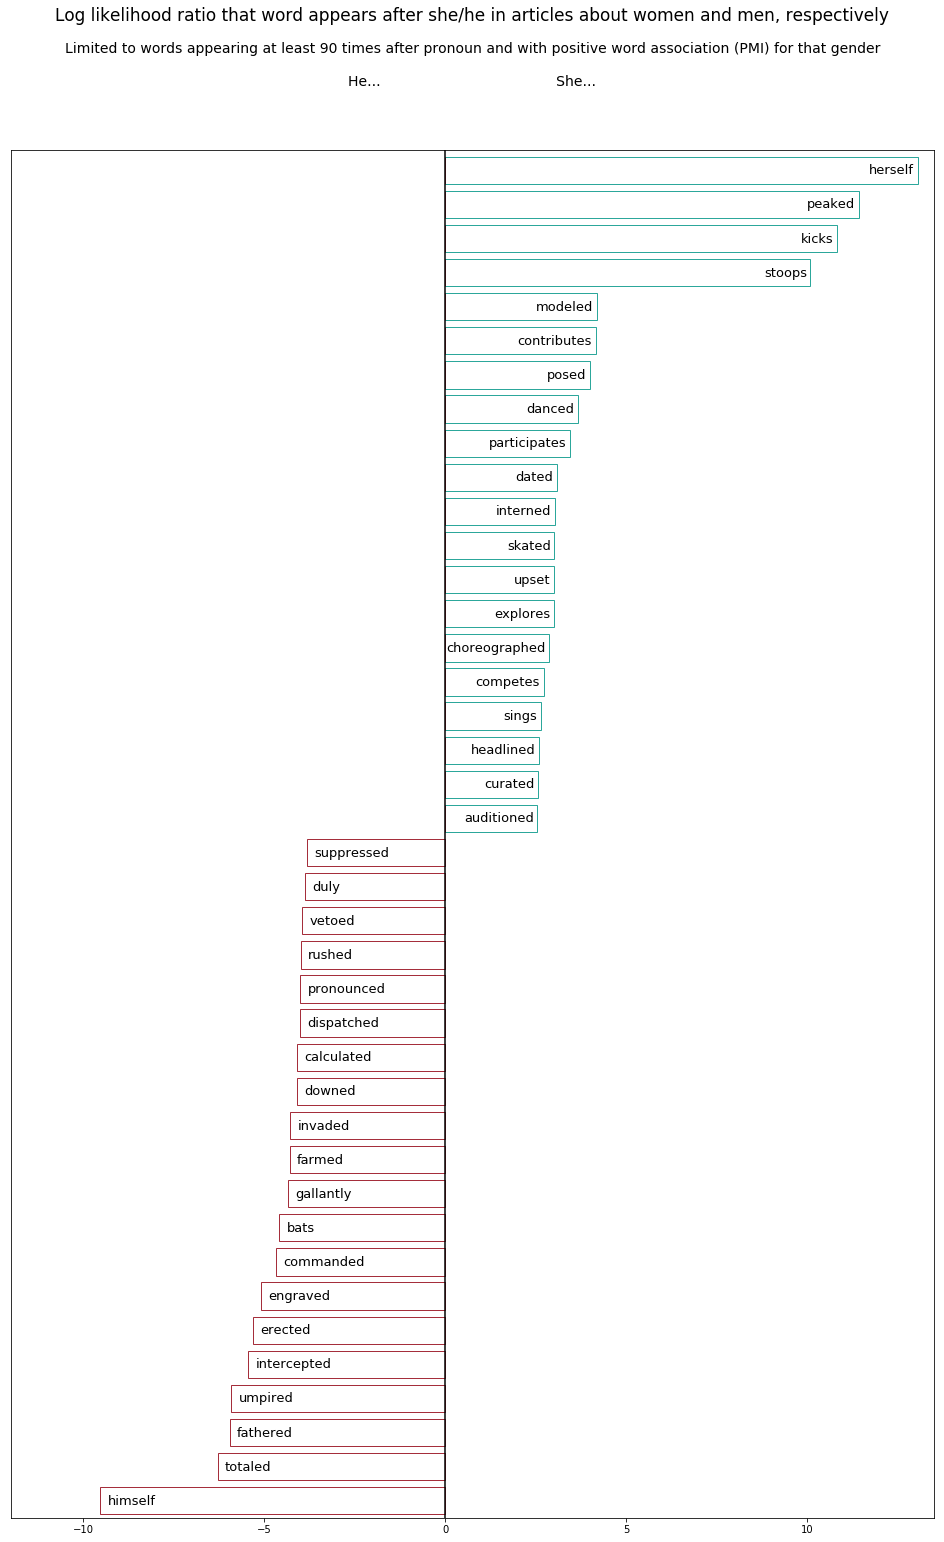

In [30]:
title="Log likelihood ratio that word appears after she/he in articles about women and men, respectively"
subtitle="Limited to words appearing at least 90 times after pronoun and with positive word association (PMI) for that gender"
subtitle2="\n\nHe...                                       She..."

Y = np.arange(40)

X_women = np.concatenate((np.zeros(20), np.flip(X1.values, 0)), axis=0)
X_men = np.concatenate((np.flip(X2.values, 0), np.zeros(20)), axis=0)

plt.figure(figsize=(13.5,20))
plt.axes([0.025, 0.025, 0.95, 0.95])
plt.barh(Y, X_women, facecolor="None", edgecolor='#2ca79b')
plt.barh(Y, X_men, facecolor="None", edgecolor='#a52e3b')

for x, y, label in zip(X_women, Y, np.concatenate((np.empty(20, dtype="U") , np.flip(Y1,0)))):
    plt.text(x-0.1, y, label, ha='right', va= 'center', color="black", fontsize=13)
for x, y, label in zip(X_men, Y, np.concatenate((np.flip(Y2,0), np.empty(20, dtype="U")))):
    plt.text(x+0.2, y, label, ha='left', va= 'center', color="black", fontsize=13)


plt.title(title, fontsize=17, y=1.09)
plt.suptitle(subtitle + subtitle2, fontsize=14, y=1.05)
plt.axvline(x=0, color="black")
plt.ylim(-.5, 39.6)
plt.yticks(())
plt.xlim(-12, 13.5)
plt.show()